## <a id='0'>Contents </a>

- <a href='#0'>Contents</a>
- <a href='#1'>1.Import Packages</a>
- <a href='#2'>2.Set Root Directory </a>
- <a href='#3'>3.Read Data file(s)</a>
- <a href='#4'>4.Data OverView</a>
    - <a href='#4.1'>4.1 Adding Additional Columns </a>
- <a href='#5'>5.Creating DFTrain, DFVal and DFTest </a>
- <a href='#6'>6. Column Selectors </a>
    - <a href='#6-1'>6.1 Custom Transformers for ShirtSizing</a>
    - <a href='#6-2'>6.2 Pipeline for ShirtSizing </a>
    - <a href='#6-3'>6.3 Custom Transformers for MeanEncoding </a>
    - <a href='#6-4'>6.4 Pipelines for MeanEncoding </a>
- <a href='#7'>7. ML Model Evaluation And Building ML Model</a>
    - <a href='#7.1'>7.1 ML Model Evaluation  </a>
    - <a href='#7.2'>7.2 ML Model </a>
- <a href='#8'>8. Predictions </a>

# <a id = '1'>1. Import the required packages </a>

#### <a href='#0'>Go To TOp</a>

In [1]:
import os
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import pandas_profiling
import xgboost as xgb
import matplotlib.pyplot as plt
from datetime import datetime, date
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_auc_score,accuracy_score, log_loss, roc_curve,f1_score,confusion_matrix,precision_score,recall_score
from sklearn.preprocessing import LabelEncoder,StandardScaler,LabelBinarizer, OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split,cross_validate

%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

# <a id = '2'> 2. Setting up Folder Paths </a>
#### <a href='#0'>Go To TOp</a>

In [2]:
# This variable should be the only one that requires adjustment on each developer's machine

PROJECT_ROOT_FOLDER = 'C:/Users/Kishan/Desktop/SupplyChain-SAP/'

# ----------------------------------------------------------------
# These variables shouldn't have to be updated on each dev machine
RAW_DATA_FOLDER       = PROJECT_ROOT_FOLDER + 'data/rawdata/'
PROCESSED_DATA_FOLDER = PROJECT_ROOT_FOLDER + 'data/processeddata/'
OUTPUT_FOLDER         = PROJECT_ROOT_FOLDER + 'output/'

#SPRINT_DATA_FOLDER    = PROCESSED_DATA_FOLDER + 'sprint1/'
#SPRINT_OUTPUT_FOLDER  = OUTPUT_FOLDER + 'sprint1/'

####  Ensure that the paths exist in the local environment

In [3]:
# quick check-point to make sure all the folders exist locally
assert \
os.path.exists(PROJECT_ROOT_FOLDER)    and \
os.path.exists(RAW_DATA_FOLDER)        and \
os.path.exists(PROCESSED_DATA_FOLDER) #and \
#os.path.exists(SPRINT_DATA_FOLDER)    # and \
#os.path.exists(SPRINT_OUTPUT_FOLDER)

# <a id = '3'> 3. Reading Data </a>
#### <a href='#0'>Go To TOp</a>

In [4]:
PROCESSED_DATA_FOLDER

'C:/Users/Kishan/Desktop/SupplyChain-SAP/data/processeddata/'

In [5]:
#Reading Supply Chain file

df = pd.read_csv(PROCESSED_DATA_FOLDER + 'Clean_CuratedBaseDataset_order_Gran_Clusters.csv'
                 #,sep='|'
                 ,encoding = "latin-1"
                # ,error_bad_lines=False
                 ,parse_dates=True
                )

In [6]:
df.shape

(65752, 68)

In [7]:
df.head()

,customer_city,customer_country,customer_email,customer_firstname,customer_id,customer_lastname,customer_password,customer_segment,customer_state,customer_street,customer_zip,type,shipping_days_actual,shipping_days_scheduled,delivery_status,late_delivery_risk,market,order_city,order_country,order_cust_id,order_date,order_id,order_region,order_state,order_zip,shipping_date,shipping_mode,num_days_late,order_status,store_city,store_state,gapbetween_orderandship_date,samecountry_source_dest,weekend_duringshipping,weekend_duringshipping_Scheduleddays,shipping_on_weekends,ordered_on_weekends,shipping_dt_weekday,order_dt_weekday,shipping_dt_weekday_name,order_dt_weekday_name,shipping_dt_year_month,order_dt_year_month,shipping_dt_month,order_dt_month,shipping_dt_year,order_dt_year,store_country,sc_oc,order_dt_month_name,shipping_dt_month_name,latitude,longitude,order_item_count,item_qty_sum,order_item_productprice_sum,discount_sum,order_item_productprice_after_discount_sum,cat_lowvol_lowrisk,cat_lowvol_highrisk,cat_highvol_lowrisk,lowvol_lowrisk,highvol_lowrisk,lowvol_highrisk,highvol_highrisk,late_delivery,days_late_2,order_country_logistics_performance_index
0,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.00,DEBIT,3,4,Advance shipping,0,Pacific Asia,Bekasi,Indonesia,20755,2018-01-31 22:56:00,77202,Southeast Asia,Java Occidental,nan,2018-02-03 22:56:00,Standard Class,-1,COMPLETE,Caguas,Puerto Rico,3.00,Different Countries,Yes Weekend involved,Yes Weekend involved,ShippedonWeekend,OrderedonWeekday,5,2,Saturday,Wednesday,2018-02,2018-01,2,1,2018,2018,Puerto Rico,Caguas-Bekasi,January,February,18.25,-66.04,1,1,327.75,13.11,314.64,0,0,1,0,0,0,1,1,2,3
1,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.00,TRANSFER,5,4,Late delivery,1,Pacific Asia,Bikaner,India,19492,2018-01-13 12:27:00,75939,South Asia,RajastÃÂÃÂÃÂÃÂ¡n,nan,2018-01-18 12:27:00,Standard Class,1,PENDING,Caguas,Puerto Rico,5.00,Different Countries,Yes Weekend involved,Yes Weekend involved,ShippededonWeekday,OrderedonWeekend,3,5,Thursday,Saturday,2018-01,2018-01,1,1,2018,2018,Puerto Rico,Caguas-Bikaner,January,January,18.28,-66.04,1,1,327.75,16.39,311.36,0,0,1,0,0,0,1,1,4,3
2,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.00,CASH,4,4,Shipping on time,0,Pacific Asia,Bikaner,India,19491,2018-01-13 12:06:00,75938,South Asia,RajastÃÂÃÂÃÂÃÂ¡n,nan,2018-01-17 12:06:00,Standard Class,0,CLOSED,San Jose,California,4.00,Different Countries,Yes Weekend involved,Yes Weekend involved,ShippededonWeekday,OrderedonWeekend,2,5,Wednesday,Saturday,2018-01,2018-01,1,1,2018,2018,United States,San Jose-Bikaner,January,January,37.29,-121.88,1,1,327.75,18.03,309.72,0,0,1,0,0,0,1,1,2,3
3,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.00,DEBIT,3,4,Advance shipping,0,Pacific Asia,Townsville,Australia,19490,2018-01-13 11:45:00,75937,Oceania,Queensland,nan,2018-01-16 11:45:00,Standard Class,-1,COMPLETE,Los Angeles,California,3.00,Different Countries,No weekend involved,No weekend involved,ShippededonWeekday,OrderedonWeekend,1,5,Tuesday,Saturday,2018-01,2018-01,1,1,2018,2018,United States,Los Angeles-Townsville,January,January,34.13,-118.29,1,1,327.75,22.94,304.81,0,0,1,0,0,0,1,0,0,4
4,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.00,PAYMENT,2,4,Advance shipping,0,Pacific Asia,Townsville,Australia,19489,2018-01-13 11:24:00,75936,Oceania,Queensland,nan,2018-01-15 11:24:00,Standard Class,-2,PENDING_PAYMENT,Caguas,Puerto Rico,2.00,Different Countries,No weekend involved,No weekend involved,ShippededonWeekday,OrderedonWeekend,0,5,Monday,Saturday,2018-01,2018-01,1,1,2018,2018,Puerto Rico,Caguas-Townsville,January,January,18.25,-66.04,1,1,327.75,29.50,298.25,0,0,1,0,0,0,1,1,1,4


In [8]:
df.columns.tolist()

['customer_city',
 'customer_country',
 'customer_email',
 'customer_firstname',
 'customer_id',
 'customer_lastname',
 'customer_password',
 'customer_segment',
 'customer_state',
 'customer_street',
 'customer_zip',
 'type',
 'shipping_days_actual',
 'shipping_days_scheduled',
 'delivery_status',
 'late_delivery_risk',
 'market',
 'order_city',
 'order_country',
 'order_cust_id',
 'order_date',
 'order_id',
 'order_region',
 'order_state',
 'order_zip',
 'shipping_date',
 'shipping_mode',
 'num_days_late',
 'order_status',
 'store_city',
 'store_state',
 'gapbetween_orderandship_date',
 'samecountry_source_dest',
 'weekend_duringshipping',
 'weekend_duringshipping_Scheduleddays',
 'shipping_on_weekends',
 'ordered_on_weekends',
 'shipping_dt_weekday',
 'order_dt_weekday',
 'shipping_dt_weekday_name',
 'order_dt_weekday_name',
 'shipping_dt_year_month',
 'order_dt_year_month',
 'shipping_dt_month',
 'order_dt_month',
 'shipping_dt_year',
 'order_dt_year',
 'store_country',
 'sc_oc',
 'order_dt_month_name',
 'shipping_dt_month_name',
 'latitude',
 'longitude',
 'order_item_count',
 'item_qty_sum',
 'order_item_productprice_sum',
 'discount_sum',
 'order_item_productprice_after_discount_sum',
 'cat_lowvol_lowrisk',
 'cat_lowvol_highrisk',
 'cat_highvol_lowrisk',
 'lowvol_lowrisk',
 'highvol_lowrisk',
 'lowvol_highrisk',
 'highvol_highrisk',
 'late_delivery',
 'days_late_2',
 'order_country_logistics_performance_index']

In [9]:
#df['unique_id'] = df['order_id'].map(str)+'-'+df['order_item_id'].map(str)

## <a id='4'>4.Data Type Conversion</a>
<a href='#0'>Go to top </a>

In [10]:
# Converting String columns with date values to Date data type

#df['DOB'] = pd.to_datetime(df['DOB'],errors = 'coerce') 
df['order_date'] = pd.to_datetime(df['order_date'])
df['shipping_date'] = pd.to_datetime(df['shipping_date'])


### <a id='4.1'>4.1 Adding Additional Columns </a>
<a href='#0'>Go to top </a>

In [11]:
#Adding Target Variable. Reducing from multi classification problem to binary classfication

#df['late_delivery'] = df['late_delivery']

#df['sc_oc'] = df['store_city']+"-"+df['order_city']

In [12]:
#df['order_dt_year_month'] = pd.to_datetime(df['order_date']).dt.strftime('%Y-%m')
#df['shipping_dt_year_month'] = pd.to_datetime(df['shipping_date']).dt.strftime('%Y-%m')

#df['order_dt_month'] = df['order_date'].dt.month
#df['order_dt_weekday']=df['order_date'].dt.weekday

#df['shipping_dt_weekday']=df['shipping_date'].dt.weekday
#df['shipping_dt_month'] = df['shipping_date'].dt.month

#df['late_delivery'] = np.where(df['delivery_status']=='Late delivery',1,0)

#df['store_state'].fillna(df['customer_state'], inplace=True)
#df['store_city'].fillna(df['customer_city'], inplace=True)
#df['sc_oc'] = df['store_city']+"-"+df['order_city']

#df['store_country']= np.where(df['store_state']=='Puerto Rico','Puerto Rico','United States')
#df['samecountry_source_dest'] = np.where(df['store_country']==df['order_country'],'SameCountry','DifferentCountry')


#df['gapbetween_order_shipdate'] = (df['shipping_date']-df['order_date'])
#df['gapbetween_order_shipdate']=df['gapbetween_order_shipdate']/np.timedelta64(1,'D')

#df['ordered_on_weekends']= np.where(df['order_dt_weekday'].isin([5,6]),"OrderedonWeekend", "OrderedonWeekday")
#df['shipping_on_weekends']= np.where(df['shipping_dt_weekday'].isin([5,6]),"ShippedonWeekend", "ShippededonWeekday")


#df['weekend_duringshipping']=np.where(((df['shipping_on_weekends']=='ShippedonWeekend')|((df['shipping_dt_weekday']+df['shipping_days_scheduled']-1)>=5)),'Yes Weekend involved','No weekend involved')

In [13]:
df.columns

Index(['customer_city', 'customer_country', 'customer_email',
       'customer_firstname', 'customer_id', 'customer_lastname',
       'customer_password', 'customer_segment', 'customer_state',
       'customer_street', 'customer_zip', 'type', 'shipping_days_actual',
       'shipping_days_scheduled', 'delivery_status', 'late_delivery_risk',
       'market', 'order_city', 'order_country', 'order_cust_id', 'order_date',
       'order_id', 'order_region', 'order_state', 'order_zip', 'shipping_date',
       'shipping_mode', 'num_days_late', 'order_status', 'store_city',
       'store_state', 'gapbetween_orderandship_date',
       'samecountry_source_dest', 'weekend_duringshipping',
       'weekend_duringshipping_Scheduleddays', 'shipping_on_weekends',
       'ordered_on_weekends', 'shipping_dt_weekday', 'order_dt_weekday',
       'shipping_dt_weekday_name', 'order_dt_weekday_name',
       'shipping_dt_year_month', 'order_dt_year_month', 'shipping_dt_month',
       'order_dt_month', 'shippin

In [14]:
cols_notused = [ 'customer_city','customer_email', 'customer_firstname', 'customer_id',  'customer_lastname', 'customer_password',
                'customer_street','customer_zip', 'late_delivery_risk','order_cust_id', 'order_zip','num_days_late','delivery_status',
                 'order_dt_year_month','shipping_dt_year_month','shipping_days_actual','latitude', 'longitude'
               ]

cols_used =    [  'order_id'
                 ,'late_delivery' 
    
                #Customer Attributes
                 ,'customer_country','customer_segment'
                #,'sc_oc'
                ,'samecountry_source_dest'
               # ,'weekend_duringshipping_Scheduleddays'
               
                ,'ordered_on_weekends'#,'shipping_on_weekends'
                 # Not using these columns as they have very less imprtance ,'customer_country', 'customer_segment', 'customer_state'  
    
                 #,'type'
                ,  'market'
                , 'shipping_mode'
                ,'order_dt_month','store_country','order_country','order_region'
                # ,'order_city' ,'store_city'
               # ,'order_status','shipping_dt_month'
                #,'shipping_dt_weekday'
                #,  'shipping_days_scheduled'
                ,'order_dt_weekday',
                # Not suing these columns as they have very less imprtance ,'order_country',  'order_region', 'order_state'
                 
                ##### Increasing the accuracy to 99%
               #,'gapbetween_orderandship_date'
               'cat_lowvol_lowrisk','cat_lowvol_highrisk', 'cat_highvol_lowrisk',
                'lowvol_lowrisk', 'highvol_lowrisk',
                'lowvol_highrisk', 'highvol_highrisk', 'order_country_logistics_performance_index'
                
]
                


In [15]:
#Adding Target Variable. Reducing from multi classification problem to binary classfication
df_ModelDataSet =df[cols_used]

In [16]:
df_ModelDataSet.shape

(65752, 21)

In [17]:
pd.DataFrame(
     df.groupby(['order_dt_weekday','late_delivery'])
                  .agg({'order_id':'count'})
                  .reset_index()
                  .rename(columns={'order_id':'order_cnt'})
                  .sort_values(['order_cnt','late_delivery'],ascending=False)
                  .pivot(index='order_dt_weekday',columns='late_delivery',values=['order_cnt'])
                  .to_records()  
).fillna(0).rename(columns= {"('order_cnt', 0)":'late_delivery_0',"('order_cnt', 1)":'late_delivery_1'})    
   

,order_dt_weekday,late_delivery_0,late_delivery_1
0,0,3211,6157
1,1,3250,6145
2,2,3231,6166
3,3,3182,6213
4,4,3199,6201
5,5,3254,6176
6,6,3184,6183


In [18]:
temp = df[(df['late_delivery']== 0)&(((df['order_id']%2)==0)|((df['order_id']%5)==0))]

In [19]:
pd.DataFrame(
     temp.groupby(['order_dt_weekday','late_delivery'])
                  .agg({'order_id':'count'})
                  .reset_index()
                  .rename(columns={'order_id':'order_cnt'})
                  .sort_values(['order_cnt','late_delivery'],ascending=False)
                  .pivot(index='order_dt_weekday',columns='late_delivery',values=['order_cnt'])
                  .to_records()  
).fillna(0).rename(columns= {"('order_cnt', 0)":'late_delivery_0',"('order_cnt', 1)":'late_delivery_1'})    
   

,order_dt_weekday,late_delivery_0
0,0,1670
1,1,1700
2,2,1664
3,3,1635
4,4,1653
5,5,1723
6,6,1657


In [20]:
#df['late_delivery'] = np.where(((df['order_dt_weekday'].isin([0,5,6]))&(df['late_delivery']== 0)),1,0)

In [21]:
# Converting String columns with categorical values to Categorical data type

#df['type'] = df['type'].astype('object')

# LoyaltyCustomerFlag is converted to category data type later in the process
#df['LoyaltyCustomerFlag'] = df['LoyaltyCustomerFlag'].astype('category')   

# Converting Float columns with ID values to Object data type
#df['customer_id'] = df['customer_id'].astype('object')
#df['dept_id'] = df['dept_id'].astype('object')
#df['order_cust_id'] = df['order_cust_id'].astype('object')
#df['order_id'] = df['order_id'].astype('object')
#df['order_item_cardprod_id'] = df['order_item_cardprod_id'].astype('object')
#df['order_item_id'] = df['order_item_id'].astype('object')

# <a id = '5'> 5.Creating DFTrain, DFVal and DFTest </a>
#### <a href='#0'>Go To TOp</a>

#### Dataset Balancing

In [22]:
#***********************************************************************
#*********** Has to be executed if the dataset has to be balanced ******
#***********************************************************************

#df1 = df_ModelDataSet[df_ModelDataSet['AttritionFlag'] == 0]
#df1 = pd.concat((df1,df_ModelDataSet[df_ModelDataSet['AttritionFlag'] == 1].sample(842089,replace = False)),axis = 0)
#df_ModelDataSet = df1.copy()
#df_ModelDataSet.shape

In [23]:
#Creating a Random Variable to divide the dataset into Train,Val and Test

#df_ModelDataSet['Random'] = np.random.randn(len(df_ModelDataSet['unique_id']), 1)

#Creating TrainVal dataset

#DFTrainval = df_ModelDataSet[df_ModelDataSet['Random']<0.8]

#Creating Train dataset from TrainVal 

#DFTrain = DFTrainval[DFTrainval['Random']<0.6]

#Creating Val dataset from TrainVal 

#DFVal = DFTrainval[~(DFTrainval['Random']<0.6)]

#Creating Test dataset from TrainVal 

#DFTest = df_ModelDataSet[~(df_ModelDataSet['Random']<0.8)]

In [24]:
df_ModelDataSet['late_delivery'].value_counts()

1    43241
0    22511
Name: late_delivery, dtype: int64

In [25]:
df_ModelDataSet.dtypes

order_id                                      int64
late_delivery                                 int64
customer_country                             object
customer_segment                             object
samecountry_source_dest                      object
ordered_on_weekends                          object
market                                       object
shipping_mode                                object
order_dt_month                                int64
store_country                                object
order_country                                object
order_region                                 object
order_dt_weekday                              int64
cat_lowvol_lowrisk                            int64
cat_lowvol_highrisk                           int64
cat_highvol_lowrisk                           int64
lowvol_lowrisk                                int64
highvol_lowrisk                               int64
lowvol_highrisk                               int64
highvol_high

In [26]:
df_ModelDataSet.head()

,order_id,late_delivery,customer_country,customer_segment,samecountry_source_dest,ordered_on_weekends,market,shipping_mode,order_dt_month,store_country,order_country,order_region,order_dt_weekday,cat_lowvol_lowrisk,cat_lowvol_highrisk,cat_highvol_lowrisk,lowvol_lowrisk,highvol_lowrisk,lowvol_highrisk,highvol_highrisk,order_country_logistics_performance_index
0,77202,1,Puerto Rico,Consumer,Different Countries,OrderedonWeekday,Pacific Asia,Standard Class,1,Puerto Rico,Indonesia,Southeast Asia,2,0,0,1,0,0,0,1,3
1,75939,1,Puerto Rico,Consumer,Different Countries,OrderedonWeekend,Pacific Asia,Standard Class,1,Puerto Rico,India,South Asia,5,0,0,1,0,0,0,1,3
2,75938,1,EE. UU.,Consumer,Different Countries,OrderedonWeekend,Pacific Asia,Standard Class,1,United States,India,South Asia,5,0,0,1,0,0,0,1,3
3,75937,0,EE. UU.,Home Office,Different Countries,OrderedonWeekend,Pacific Asia,Standard Class,1,United States,Australia,Oceania,5,0,0,1,0,0,0,1,4
4,75936,1,Puerto Rico,Corporate,Different Countries,OrderedonWeekend,Pacific Asia,Standard Class,1,Puerto Rico,Australia,Oceania,5,0,0,1,0,0,0,1,4


In [27]:
df_ModelDataSet.shape

(65752, 21)

In [28]:
DFTrainVal = df_ModelDataSet.sample(frac =.8) 

In [29]:
DFTrainVal.shape

(52602, 21)

In [30]:
DFTrain = DFTrainVal.sample(frac =.8) 

In [31]:
DFTrain.shape

(42082, 21)

In [32]:
DFVal = DFTrainVal[(~DFTrainVal.order_id.isin(DFTrain.order_id))]

In [33]:
DFVal.shape

(10520, 21)

In [34]:
DFTest=df_ModelDataSet[(~df_ModelDataSet.order_id.isin(DFTrainVal.order_id))]

In [35]:
DFTest.shape

(13150, 21)

In [36]:
len(DFTrain)

42082

In [37]:
DFTrain.head()

,order_id,late_delivery,customer_country,customer_segment,samecountry_source_dest,ordered_on_weekends,market,shipping_mode,order_dt_month,store_country,order_country,order_region,order_dt_weekday,cat_lowvol_lowrisk,cat_lowvol_highrisk,cat_highvol_lowrisk,lowvol_lowrisk,highvol_lowrisk,lowvol_highrisk,highvol_highrisk,order_country_logistics_performance_index
32433,70785,1,EE. UU.,Home Office,Different Countries,OrderedonWeekday,Europe,First Class,10,United States,Belgium,Western Europe,0,1,0,0,0,0,1,0,4
20694,30340,1,EE. UU.,Consumer,Different Countries,OrderedonWeekday,Pacific Asia,Second Class,3,United States,New Zealand,Oceania,4,0,1,0,0,1,1,0,4
23745,34610,1,EE. UU.,Consumer,Same Country,OrderedonWeekday,USCA,First Class,5,United States,United States,West of USA,4,0,1,0,0,0,1,0,4
55798,25690,1,EE. UU.,Consumer,Different Countries,OrderedonWeekday,Pacific Asia,Standard Class,1,United States,China,Eastern Asia,0,0,1,0,0,0,1,0,3
43392,58473,0,EE. UU.,Consumer,Different Countries,OrderedonWeekday,LATAM,Standard Class,5,United States,Dominican Republic,Caribbean,2,0,1,0,0,0,1,0,2


In [38]:
len(DFVal)

10520

In [39]:
DFVal.head()

,order_id,late_delivery,customer_country,customer_segment,samecountry_source_dest,ordered_on_weekends,market,shipping_mode,order_dt_month,store_country,order_country,order_region,order_dt_weekday,cat_lowvol_lowrisk,cat_lowvol_highrisk,cat_highvol_lowrisk,lowvol_lowrisk,highvol_lowrisk,lowvol_highrisk,highvol_highrisk,order_country_logistics_performance_index
58092,17026,0,Puerto Rico,Home Office,Different Countries,OrderedonWeekend,Europe,Second Class,9,United States,France,Western Europe,6,0,1,0,0,0,1,0,4
50794,43820,1,EE. UU.,Home Office,Different Countries,OrderedonWeekend,Pacific Asia,First Class,10,United States,Turkey,West Asia,5,0,1,0,0,0,1,0,3
44054,34641,0,Puerto Rico,Corporate,Same Country,OrderedonWeekday,USCA,Standard Class,5,United States,United States,East of USA,4,0,1,0,0,0,1,0,4
39077,36733,0,Puerto Rico,Consumer,Different Countries,OrderedonWeekday,USCA,Standard Class,6,Puerto Rico,United States,South of USA,0,0,1,0,0,0,1,0,4
55490,30118,1,EE. UU.,Home Office,Different Countries,OrderedonWeekday,Pacific Asia,Standard Class,3,United States,Australia,Oceania,1,0,1,0,0,0,1,0,4


In [40]:
len(DFTest)

13150

In [41]:
DFTest.head()

,order_id,late_delivery,customer_country,customer_segment,samecountry_source_dest,ordered_on_weekends,market,shipping_mode,order_dt_month,store_country,order_country,order_region,order_dt_weekday,cat_lowvol_lowrisk,cat_lowvol_highrisk,cat_highvol_lowrisk,lowvol_lowrisk,highvol_lowrisk,lowvol_highrisk,highvol_highrisk,order_country_logistics_performance_index
12,75928,1,EE. UU.,Corporate,Different Countries,OrderedonWeekend,Pacific Asia,Second Class,1,United States,Indonesia,Southeast Asia,5,0,0,1,0,0,0,1,3
14,75926,1,EE. UU.,Corporate,Different Countries,OrderedonWeekend,Pacific Asia,First Class,1,United States,India,South Asia,5,0,0,1,0,0,0,1,3
40,75900,1,EE. UU.,Consumer,Different Countries,OrderedonWeekday,Pacific Asia,Same Day,1,United States,Singapur,Southeast Asia,4,0,0,1,0,0,0,1,1
41,75899,1,Puerto Rico,Home Office,Different Countries,OrderedonWeekday,Pacific Asia,Same Day,1,Puerto Rico,Singapur,Southeast Asia,4,0,0,1,0,0,0,1,1
42,75898,1,EE. UU.,Home Office,Different Countries,OrderedonWeekday,Pacific Asia,Standard Class,1,United States,Indonesia,Southeast Asia,4,0,0,1,0,0,0,1,3


# <a id = '6'> 6. Columns Selector </a>
#### <a href='#0'>Go To TOp</a>

In [42]:
#Defining id_col, target_col and Shirtsize_cols

id_col = 'order_id'
target_col = 'late_delivery'

               
#shirtsize_cols = [#'order_item_qty' ,'total_product_price', 'discounted_total_product_price'
                 # ,"Diamondback Boys' Insight 24 Performance Hybr", 'GoPro HERO3+ Black Edition Camera', 'Ogio Race Golf Shoes'
                 #,'Pelican Maverick 100X Kayak', 'SOLE E25 Elliptical', 'Team Golf St. Louis Cardinals Putter Grip'
                 #,'Titleist Club Glove Travel Cover', 'Titleist Small Wheeled Travel Cover', 'Total Gym 1400', 'other_prods'
                # ,'Accessories', 'As Seen on  TV!', 'Cameras ','Fitness Accessories', 'Golf Bags & Carts', 'Lacrosse'
                 #,'Music','Pet Supplies','Strength Training', 'other_cats'
#                 ]


In [43]:
#Custom Transformer that extracts columns passed as argument to its constructor 

class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self._feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self._feature_names ] 

# <a id = '6-1'> 6.1 Custom Transformer Shirt Sizing </a>

####  (No Need to execute 6.1 and 6.2 sections, as there are no numerical values to be convetred to categorical values )  
#### <a href='#0'>Go To Top</a>

In [44]:
#Funtions to create bins dynamically 

#cut = []
#settings = {}
#class DFShirtSize(BaseEstimator, TransformerMixin):
#    def __init__(self,columns = None):
#        self.columns = columns # array of column names to encode

#    def fit(self,X,y=None):
#        df = X.copy()
#        if self.columns is not None:
#            for col_name in self.columns:
#                df[col_name] = df[col_name].fillna(0)
#                colmin = (abs(df[col_name].min())+1)
#                cuts = pd.cut(
#                             np.log(colmin + df[col_name]),
#                             bins = 4,
#                             labels=['1_small','2_medium','3_large','4_xlarge',],
#                             retbins = True
#                           )[1]
#                cuts[0], cuts[-1] = -np.inf, np.inf
#                tempsettings = {col_name: cuts}
#                settings.update(tempsettings)
#    def transform(self,X):
#        df = X.copy()
#        for col, cuts in settings.items():
#                #col_name_ss = col + '_ss'
#                df[col] = df[col].fillna(0)
#                df[col] = pd.cut(
#                                            np.log(1 + df[col]),
#                                            bins = cuts,
#                                            labels=['1_small','2_medium','3_large','4_xlarge']      
#                                        )
#       
#        return df
#        
#    def fit_transform(self,X,y=None):
#        return self.fit(X,y).transform(X)
#

# <a id = '6-2'>6.2 Pipeline for ShirtSizing </a>
#### <a href='#0'>Go To Top</a>

In [45]:
#SSEncoding = [
#              ('Column Selector',FeatureSelector(shirtsize_cols)),
#              ('Shirt Sizing', DFShirtSize(shirtsize_cols)),
#             ]

In [46]:
#pipe_sse = Pipeline(SSEncoding)

In [47]:
#pipe_sse.fit(DFTrain)

In [48]:
#Transforming the given dataset

#DFTrain_SSE = pipe_sse.transform(DFTrain)

In [49]:
#Transforming the given dataset

#DFVal_SSE =  pipe_sse.transform(DFVal)

In [50]:
#Transforming the given dataset

#DFTest_SSE =  pipe_sse.transform(DFTest)

In [51]:
#Assigning back shirtsized columns to actual datset

#for col in shirtsize_cols:
#    DFTrain[col] = DFTrain_SSE[col]
#    DFVal[col] = DFVal_SSE[col]
 #   DFTest[col] = DFTest_SSE[col]

In [52]:
#DFTrain.head()

In [53]:
#DFVal.head()

In [54]:
#DFTest.head()

# <a id = '6-3'> 6.3 Custom Transofmer for Mean Encoding </a>
#### <a href='#0'>Go To Top</a>

In [55]:
#Defining Mean Encoding columns

#mean_enc_cols = DFTrain.drop(columns = [id_col,target_col,'Random']).columns.tolist()
mean_enc_cols = DFTrain.drop(columns = [id_col,target_col]).columns.tolist()
#mean_enc_cols

In [56]:
DFTrain.dtypes

order_id                                      int64
late_delivery                                 int64
customer_country                             object
customer_segment                             object
samecountry_source_dest                      object
ordered_on_weekends                          object
market                                       object
shipping_mode                                object
order_dt_month                                int64
store_country                                object
order_country                                object
order_region                                 object
order_dt_weekday                              int64
cat_lowvol_lowrisk                            int64
cat_lowvol_highrisk                           int64
cat_highvol_lowrisk                           int64
lowvol_lowrisk                                int64
highvol_lowrisk                               int64
lowvol_highrisk                               int64
highvol_high

In [57]:
#Converting to Mean Encoding columns to Category type

for col in mean_enc_cols: 
    if col != target_col:
        DFTrain.loc[:, col] = DFTrain.loc[:, col].astype('category') 
        DFVal.loc[:, col] = DFVal.loc[:, col].astype('category') 
        DFTest.loc[:, col]   =   DFTest.loc[:, col].astype('category')

In [58]:
#Mean Encoding Function

mean_enc_settings = {}
alpha = 5 # (1) can be tuned as a hyper-parameter, (2) can be tuned on a column-by-column basis
prior = 0 
class DFMeanEncoding(BaseEstimator, TransformerMixin):
    def __init__(self,columns = None,df_target_col = None):
        self.columns = columns # array of column names to encode
        self.df_target_col = df_target_col

    def fit(self,X,y=None):
        df = X.copy()
        target_col = 'late_delivery'
        df[target_col] = self.df_target_col
        prior_loc = df[target_col].mean() # global mean for Train fold
        global prior 
        prior = prior_loc
        if self.columns is not None:
            for col in self.columns: #iterate though the columns we want to encode
#                 if col != target_col:
                means     = df.groupby(col)[target_col].mean()
                nrows_cnt = df.groupby(col)[target_col].count()
                means_reg = (means*nrows_cnt + prior*alpha) / (nrows_cnt + alpha)
                mean_enc_settings.update({
                     col: means_reg.to_dict()
                })
        #return self # not relevant here
        
    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        df = X.copy()
        for col, means in mean_enc_settings.items(): #iterate though the columns we want to encode
            df[col] = df[col].map(means).astype(np.float32).fillna(prior)
        return df

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)


In [59]:
MeanEncoding = [
              ('Column Selector',FeatureSelector(mean_enc_cols)),
              ('Mean Encoding', DFMeanEncoding(mean_enc_cols,DFTrain[[target_col]])),
             ]

# <a id = '6-4'> 6.4 Pipeline for Mean Encoding </a>
#### <a href='#0'>Go To Top</a>

In [60]:
pipe_me = Pipeline(MeanEncoding)

In [61]:
pipe_me.fit(DFTrain)

Pipeline(memory=None,
         steps=[('Column Selector', FeatureSelector(feature_names=None)),
                ('Mean Encoding',
                 DFMeanEncoding(columns=['customer_country', 'customer_segment',
                                         'samecountry_source_dest',
                                         'ordered_on_weekends', 'market',
                                         'shipping_mode', 'order_dt_month',
                                         'store_country', 'order_country',
                                         'order_region', 'order_dt_weekday',
                                         'cat_lowvol_lowrisk',
                                         'cat_lowvol_highrisk',
                                         'cat_highvol_lowrisk',
                                         'lowvol_lowrisk', 'highvol_lowrisk',
                                         'lowvol_highrisk', 'highvol_highrisk',
                                         'order_country_logistics_perf

In [62]:
#Transforming the given the dataset

DFTrain_ME = pipe_me.transform(DFTrain)

In [63]:
DFTrain_ME .head()

,customer_country,customer_segment,samecountry_source_dest,ordered_on_weekends,market,shipping_mode,order_dt_month,store_country,order_country,order_region,order_dt_weekday,cat_lowvol_lowrisk,cat_lowvol_highrisk,cat_highvol_lowrisk,lowvol_lowrisk,highvol_lowrisk,lowvol_highrisk,highvol_highrisk,order_country_logistics_performance_index
32433,0.66,0.67,0.67,0.66,0.56,0.96,0.54,0.66,0.55,0.56,0.66,0.59,0.77,0.64,0.66,0.66,0.64,0.64,0.61
20694,0.66,0.66,0.67,0.66,0.83,0.82,0.65,0.66,0.91,0.89,0.66,0.66,0.64,0.64,0.66,0.67,0.64,0.64,0.61
23745,0.66,0.66,0.55,0.66,0.55,0.96,0.55,0.66,0.55,0.54,0.66,0.66,0.64,0.64,0.66,0.66,0.64,0.64,0.61
55798,0.66,0.66,0.67,0.66,0.83,0.53,0.87,0.66,0.79,0.78,0.66,0.66,0.64,0.64,0.66,0.66,0.64,0.64,0.72
43392,0.66,0.66,0.67,0.66,0.64,0.53,0.55,0.66,0.67,0.66,0.65,0.66,0.64,0.64,0.66,0.66,0.64,0.64,0.66


In [64]:
DFTrain_ME.dtypes

customer_country                             float32
customer_segment                             float32
samecountry_source_dest                      float32
ordered_on_weekends                          float32
market                                       float32
shipping_mode                                float32
order_dt_month                               float32
store_country                                float32
order_country                                float32
order_region                                 float32
order_dt_weekday                             float32
cat_lowvol_lowrisk                           float32
cat_lowvol_highrisk                          float32
cat_highvol_lowrisk                          float32
lowvol_lowrisk                               float32
highvol_lowrisk                              float32
lowvol_highrisk                              float32
highvol_highrisk                             float32
order_country_logistics_performance_index    f

In [65]:
#Transforming the given the dataset

DFVal_ME = pipe_me.transform(DFVal)

In [66]:
DFVal_ME.dtypes

customer_country                             float32
customer_segment                             float32
samecountry_source_dest                      float32
ordered_on_weekends                          float32
market                                       float32
shipping_mode                                float32
order_dt_month                               float32
store_country                                float32
order_country                                float32
order_region                                 float32
order_dt_weekday                             float32
cat_lowvol_lowrisk                           float32
cat_lowvol_highrisk                          float32
cat_highvol_lowrisk                          float32
lowvol_lowrisk                               float32
highvol_lowrisk                              float32
lowvol_highrisk                              float32
highvol_highrisk                             float32
order_country_logistics_performance_index    f

In [67]:
#Transforming the given the dataset

DFTest_ME = pipe_me.transform(DFTest)

In [68]:
#Assigning back Id Col

DFTrain_ME[id_col]=DFTrain[id_col]
DFVal_ME[id_col]=DFVal[id_col]


DFTrain_ME[target_col]=DFTrain[target_col]
DFVal_ME[target_col]=DFVal[target_col]

DFTest_ME[id_col]=DFTest[id_col]
DFTest_ME[target_col]=DFTest[target_col]

                           

In [69]:
#Creating a copy of Train, Val and Test

df_train = DFTrain_ME.drop(columns = id_col).copy()
df_val   =  DFVal_ME.drop(columns = id_col).copy()
df_test =  DFTest_ME.drop(columns = id_col).copy()

In [70]:
#Creating X and y for Train, Val and Test

X_train = df_train.drop(columns = target_col)
y_train = df_train[target_col].values

X_val = df_val.drop(columns = target_col)
y_val = df_val[target_col].values

X_test = df_test.drop(columns = target_col)
y_test = df_test[target_col].values  

In [71]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, 

((42082, 19), (42082,), (10520, 19), (10520,))

In [72]:
#sorted(X_train.columns)

In [73]:
#y_train

# <a id = '7'> 7. ML Model </a>
#### <a href='#0'>Go To Top</a>

## <a id='7.1'> 7.1 ML Model Evaluation </a>
#### <a href='#0'>Go To Top</a>

In [74]:
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("lgbm",lgb.LGBMClassifier()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))

In [75]:
for name,model in models:
    kfold = KFold(n_splits=2, random_state=0)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

LR [0.73822537 0.74288294]
NB [0.70438667 0.69307542]
RF [0.71175324 0.71569792]
lgbm [0.75428924 0.75690319]
Dtree [0.67301934 0.67872249]
XGB [0.74174231 0.74383347]
KNN [0.72187634 0.72420512]


## <a id='7.2'> 7.2 ML Model</a>
#### <a href='#0'>Go To Top</a>

In [76]:
# lgb_params = {
#    'objective': 'binary',
#    'learning_rate': 0.1, 
#    'n_estimators': 1000,
#    'metric': ['auc', 'binary_logloss', ],
# }

lgb_params = {
    'max_bin': 100,
    'objective': 'binary',
    'learning_rate': 0.01,
    'n_estimators': 1000,
    'boosting_type': 'gbdt',
    'metric': ['auc', 'binary_logloss',],
    'boost_from_average': True
}

evals_result = {}  # holder to record eval results for plotting

lgb_train = lgb.Dataset(
    X_train,
    label = y_train, 
    free_raw_data = False,
)

#### FOR VALIDATION RUN ####

lgb_val = lgb.Dataset(
   X_val,
   label = y_val, 
   reference = lgb_train, 
   free_raw_data = False,
)

model = lgb.train(
    lgb_params,
    lgb_train,
    valid_sets = [lgb_train, lgb_val],
    evals_result = evals_result,
    early_stopping_rounds = 10000,
    verbose_eval = 100
)

Training until validation scores don't improve for 10000 rounds
[100]	training's auc: 0.814873	training's binary_logloss: 0.512012	valid_1's auc: 0.802997	valid_1's binary_logloss: 0.514073
[200]	training's auc: 0.818351	training's binary_logloss: 0.486912	valid_1's auc: 0.802911	valid_1's binary_logloss: 0.490848
[300]	training's auc: 0.820021	training's binary_logloss: 0.480788	valid_1's auc: 0.80339	valid_1's binary_logloss: 0.486664
[400]	training's auc: 0.823201	training's binary_logloss: 0.47782	valid_1's auc: 0.803514	valid_1's binary_logloss: 0.485886
[500]	training's auc: 0.825617	training's binary_logloss: 0.475532	valid_1's auc: 0.803588	valid_1's binary_logloss: 0.485766
[600]	training's auc: 0.828455	training's binary_logloss: 0.473465	valid_1's auc: 0.803377	valid_1's binary_logloss: 0.485854
[700]	training's auc: 0.830925	training's binary_logloss: 0.471448	valid_1's auc: 0.803636	valid_1's binary_logloss: 0.48597
[800]	training's auc: 0.833171	training's binary_logloss:

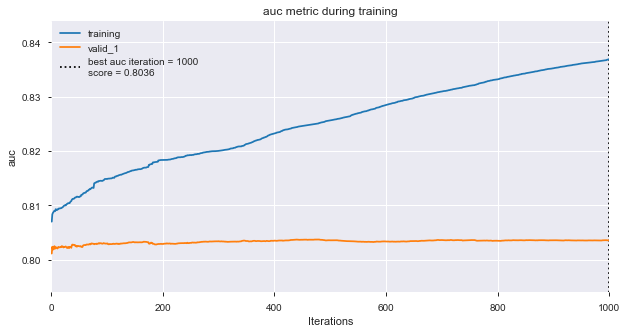

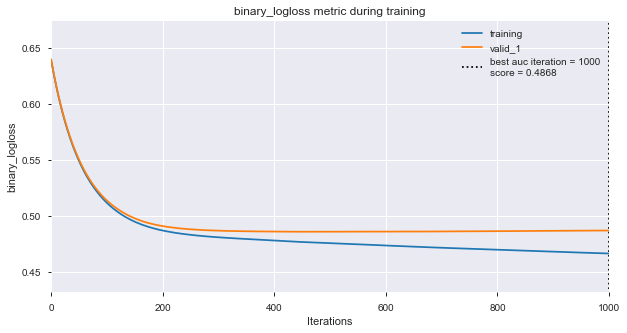

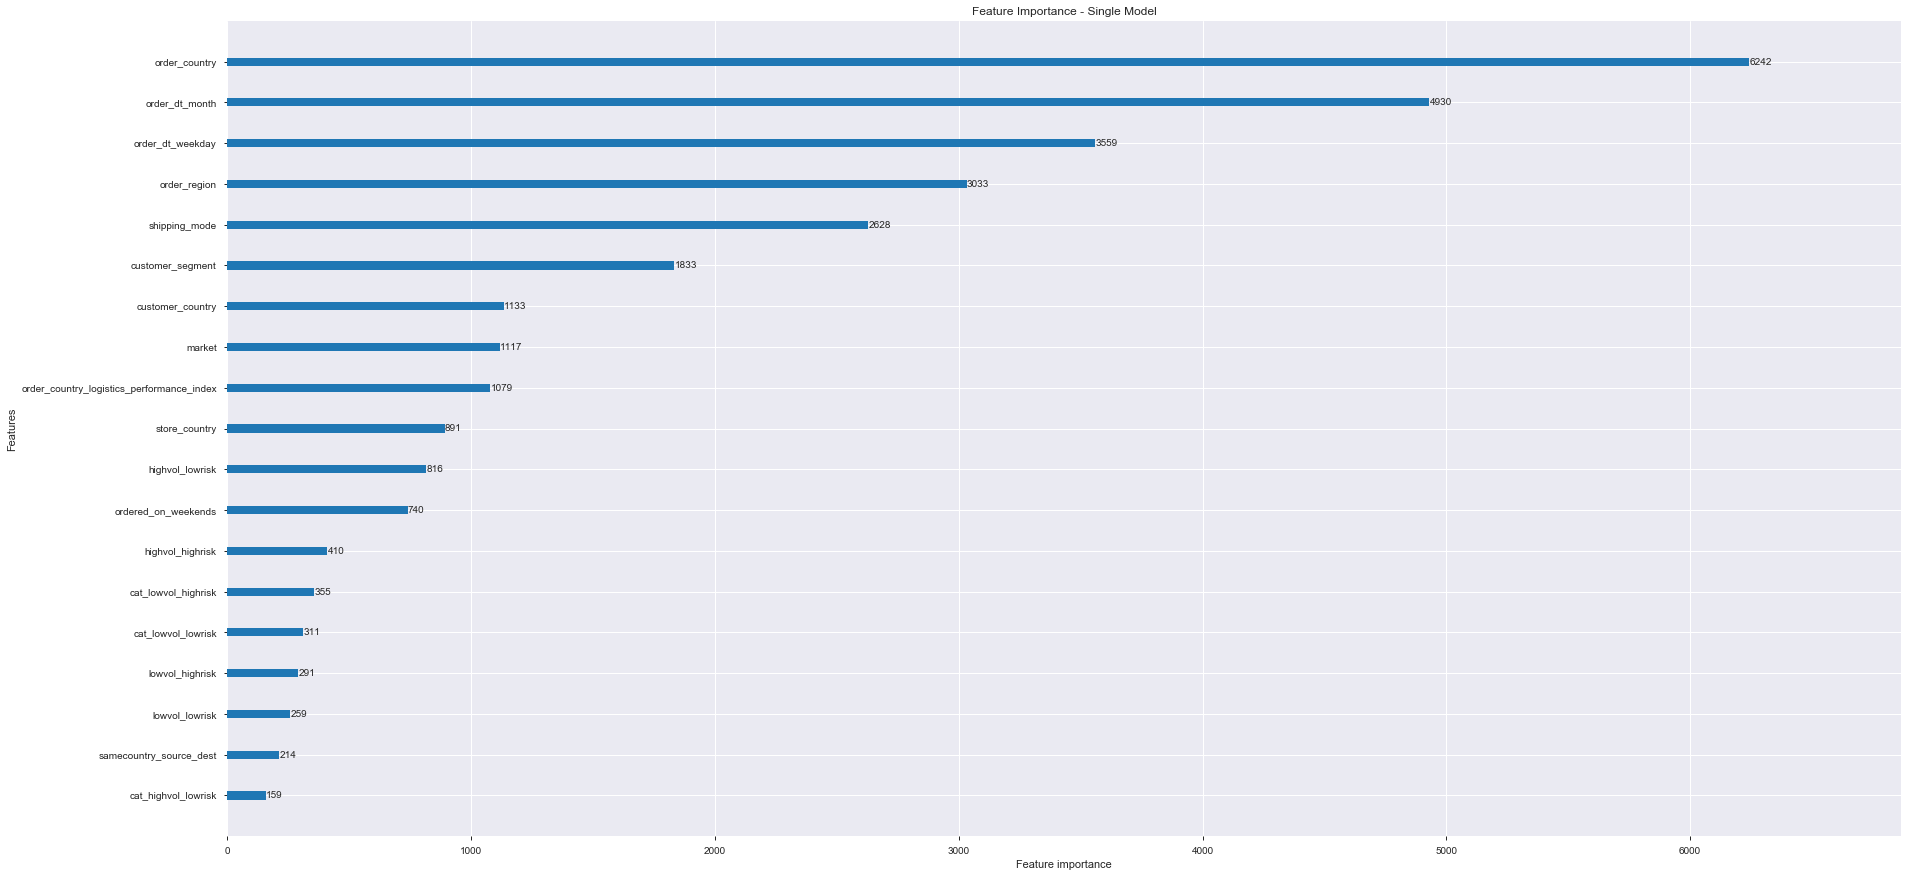

In [77]:
for metric in lgb_params['metric']:
    lgb.plot_metric(
        evals_result, figsize=(10, 5), 
        metric = metric,
        title = '{} metric during training'.format(metric),
    )
    plt.vlines(model.best_iteration, 
               0, 1, linestyles = 'dotted',
               label = 'best auc iteration = {}\nscore = {:.4f}'.format(
                   model.best_iteration, 
                   model.best_score['valid_1'][metric]))
    plt.legend()
    plt.show()

lgb.plot_importance(model, figsize=(30, 15), ignore_zero = False, )
plt.title('Feature Importance - Single Model');

# <a id = '8'> 8.Predictions  </a>
#### <a href='#0'>Go To Top</a>

In [78]:
y_hat_train = model.predict(X_train)

In [79]:
roc_auc_score(y_train, y_hat_train)

0.8368645373503885

In [80]:
log_loss(y_train, y_hat_train)

0.4663237043410506

In [81]:
accuracy_score(y_train, round(pd.DataFrame(y_hat_train)))

0.7666935982130126

In [82]:
precision_score(y_train, round(pd.DataFrame(y_hat_train)))

0.8794347309455101

In [83]:
recall_score(y_train, round(pd.DataFrame(y_hat_train)))

0.7481227436823105

In [84]:
f1_score(y_train, round(pd.DataFrame(y_hat_train)))

0.8084815855181023

In [85]:
temp_train = pd.DataFrame(y_train)


In [86]:
temp_train[0].value_counts()

1    27700
0    14382
Name: 0, dtype: int64

In [87]:
temp = round(pd.DataFrame(y_hat_train))#.value_counts()


In [88]:
temp[0].value_counts()

1.00    23564
0.00    18518
Name: 0, dtype: int64

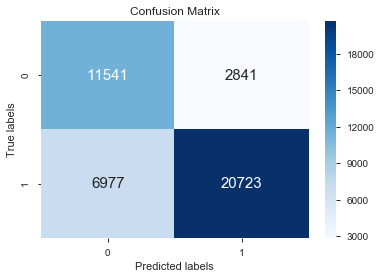

In [89]:
labels = [0, 1]
confusion_mat = confusion_matrix(y_train, round(pd.DataFrame(y_hat_train)),labels)
ax= plt.subplot()
sns.heatmap(confusion_mat, annot=True,annot_kws={"size": 15}, ax = ax,fmt='g',cmap=plt.cm.Blues); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
#ax.xaxis.set_ticklabels(['Ontime', 'Delayed']); ax.yaxis.set_ticklabels(['Ontime', 'Delayed']);
plt.show()

In [90]:
confusion_mat

array([[11541,  2841],
       [ 6977, 20723]], dtype=int64)

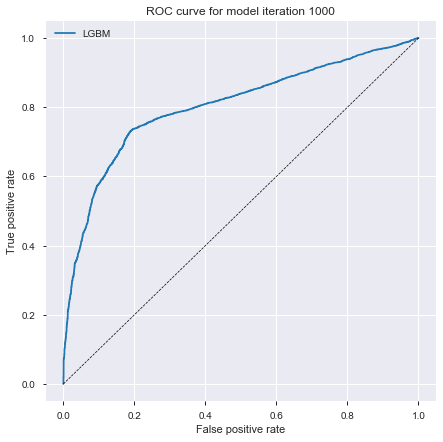

In [91]:
# build a quick ROC plot for the best model
from sklearn.metrics import roc_curve

y_hat_val = model.predict(
    X_val
)
fpr_grd, tpr_grd, _ = roc_curve(y_val, y_hat_val)

plt.figure(figsize = (7, 7))
plt.plot(fpr_grd, tpr_grd, label='LGBM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for model iteration ' + str(model.best_iteration))
plt.legend(loc='best')
plt.plot([0, 1], [0, 1], 'k--', linewidth = '0.7')
plt.show()

In [92]:
from sklearn.metrics import roc_auc_score

roc_auc_score(
   y_val, y_hat_val
)

0.8035911408156712

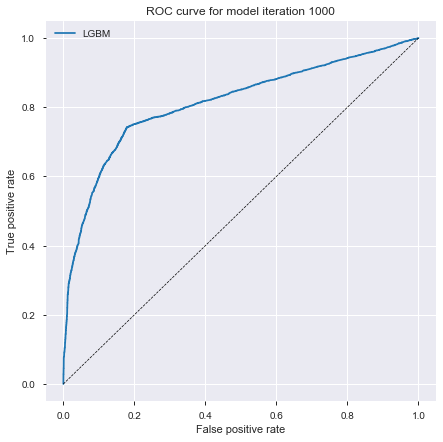

In [93]:
# build a quick ROC plot for the best model
from sklearn.metrics import roc_curve

y_hat = model.predict(
    X_test
)
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_hat)

plt.figure(figsize = (7, 7))
plt.plot(fpr_grd, tpr_grd, label='LGBM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for model iteration ' + str(model.best_iteration))
plt.legend(loc='best')
plt.plot([0, 1], [0, 1], 'k--', linewidth = '0.7')
plt.show()

In [94]:
from sklearn.metrics import roc_auc_score

roc_auc_score(
   y_test, y_hat
)

0.8138572827231608

In [95]:
#Print model report:
from sklearn.metrics import accuracy_score, log_loss, roc_curve,f1_score,confusion_matrix

In [96]:
y_hat_round = round(pd.DataFrame(y_hat))
print ("\nModel Report")
accuraryScore = accuracy_score(y_test, y_hat_round)
print("Accuracy: {:.2%}".format(accuraryScore))


Model Report
Accuracy: 76.87%


In [97]:
# Experimenting with LogLoss
logLoss = log_loss(y_test, y_hat)
#print("Log Loss: {:.2%}".format(logLoss))
print("Log Loss: {:5.2f}".format(logLoss))

Log Loss:  0.48


In [98]:
f1Score = f1_score(y_test, y_hat_round) # calculating f1 score
print("f score : {:.2%}".format(f1Score))
print("="*30)

f score : 80.90%


In [99]:
precision_score(y_test, y_hat_round)

0.8822965195944095

In [100]:
recall_score(y_test, y_hat_round)

0.7468971117039787

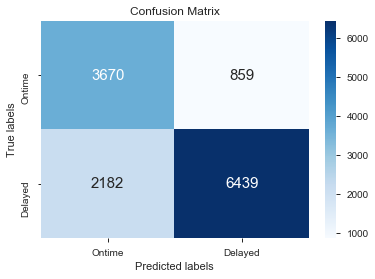

In [101]:
labels = [0, 1]
confusion_mat = confusion_matrix(y_test, y_hat_round,labels)
ax= plt.subplot()
sns.heatmap(confusion_mat, annot=True,annot_kws={"size": 15}, ax = ax,fmt='g',cmap=plt.cm.Blues); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Ontime', 'Delayed']); ax.yaxis.set_ticklabels(['Ontime', 'Delayed']);ax= plt.subplot()
plt.show()

In [102]:
confusion_mat

array([[3670,  859],
       [2182, 6439]], dtype=int64)

Feature Importance ranking
Train dataset


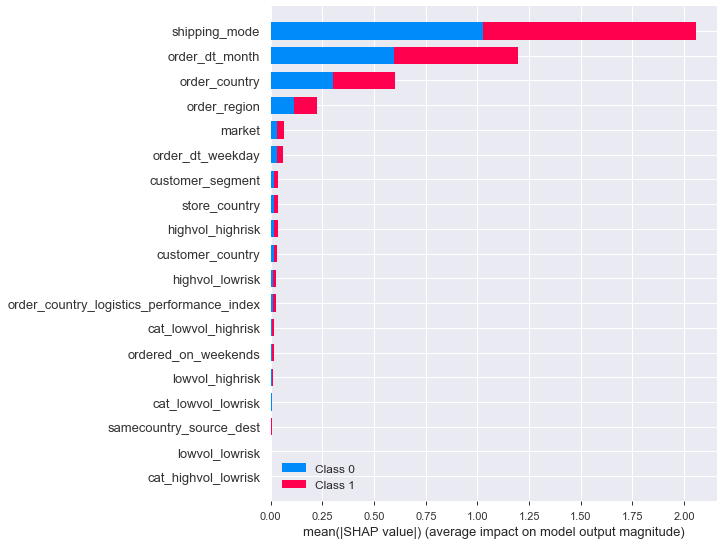

Test dataset


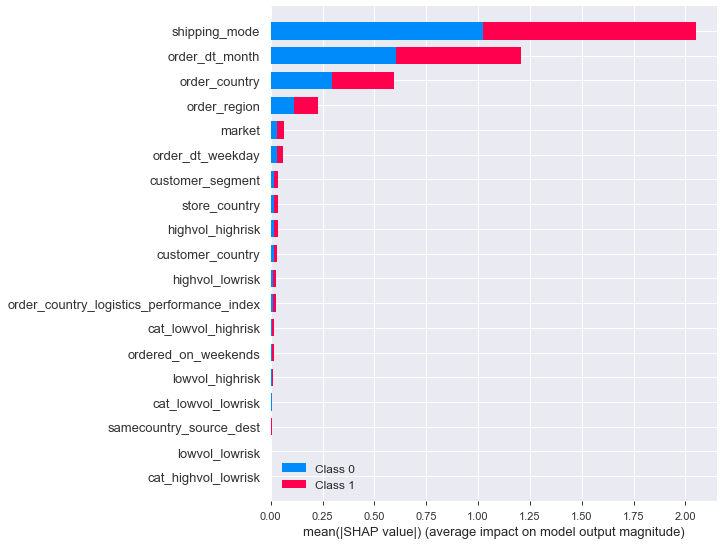

In [103]:
#%%time
# # 40.1 s

import shap

#load JS visualization code to notebook
shap.initjs()

explainer = shap.TreeExplainer(model)

print('Feature Importance ranking')
print('Train dataset')
shap_values_train = explainer.shap_values(
     X_train
)

shap.summary_plot(
     shap_values_train,     
     X_train,
     plot_type = "bar",
)

print('Test dataset')
shap_values_test = explainer.shap_values(
     X_test
)

shap.summary_plot(
     shap_values_test,     
     X_test,
     plot_type = "bar",
)

In [104]:
DFTest

,order_id,late_delivery,customer_country,customer_segment,samecountry_source_dest,ordered_on_weekends,market,shipping_mode,order_dt_month,store_country,order_country,order_region,order_dt_weekday,cat_lowvol_lowrisk,cat_lowvol_highrisk,cat_highvol_lowrisk,lowvol_lowrisk,highvol_lowrisk,lowvol_highrisk,highvol_highrisk,order_country_logistics_performance_index
12,75928,1,EE. UU.,Corporate,Different Countries,OrderedonWeekend,Pacific Asia,Second Class,1,United States,Indonesia,Southeast Asia,5,0,0,1,0,0,0,1,3
14,75926,1,EE. UU.,Corporate,Different Countries,OrderedonWeekend,Pacific Asia,First Class,1,United States,India,South Asia,5,0,0,1,0,0,0,1,3
40,75900,1,EE. UU.,Consumer,Different Countries,OrderedonWeekday,Pacific Asia,Same Day,1,United States,Singapur,Southeast Asia,4,0,0,1,0,0,0,1,1
41,75899,1,Puerto Rico,Home Office,Different Countries,OrderedonWeekday,Pacific Asia,Same Day,1,Puerto Rico,Singapur,Southeast Asia,4,0,0,1,0,0,0,1,1
42,75898,1,EE. UU.,Home Office,Different Countries,OrderedonWeekday,Pacific Asia,Standard Class,1,United States,Indonesia,Southeast Asia,4,0,0,1,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65732,27488,1,EE. UU.,Consumer,Different Countries,OrderedonWeekend,Pacific Asia,Standard Class,2,United States,Indonesia,Southeast Asia,5,0,1,0,0,0,1,0,3
65733,27426,1,EE. UU.,Corporate,Different Countries,OrderedonWeekday,Pacific Asia,Standard Class,2,United States,India,South Asia,4,0,1,0,0,0,1,0,3
65735,27353,1,Puerto Rico,Consumer,Different Countries,OrderedonWeekday,Pacific Asia,Second Class,2,United States,India,South Asia,3,0,1,0,0,0,1,0,3
65737,27197,1,Puerto Rico,Corporate,Different Countries,OrderedonWeekday,Pacific Asia,Second Class,2,United States,Cambodia,Southeast Asia,0,0,1,0,0,0,1,0,2


In [105]:
y_hat.shape

(13150,)

In [106]:
#DFTest.assign(model_predictions = y_hat)[['order_id','model_predictions']].to_csv('Test_Predictions.csv',index=False,sep=",")

In [107]:
#Done!